In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = {}

#import excel file sheets into pandas dataframe dictionary
with pd.ExcelFile('dataset.xlsx') as xls:
    for sheet in xls.sheet_names:
        df[sheet] = pd.read_excel(xls,sheet)

Print the first five rows of the `user_message` sheet to test data loading.

In [5]:
df['user_message'].head(5)

,user_id,content_created_date,content_count,total_engagement
0,20,2015-01-01,1,52
1,20,2015-01-02,1,72
2,20,2015-01-10,1,83
3,20,2015-01-12,1,45
4,20,2015-01-16,1,102


Check for unique values in provided dataset

In [6]:
for sheet in df.keys():
    users=df[sheet]['user_id']
    print("There are {total} values, {unique} of which are unique, in {sheet}".format(
        total=len(users),unique=len(set(users)),sheet=sheet))

There are 5317 values, 5317 of which are unique, in user_features
There are 5317 values, 5317 of which are unique, in user
There are 28371 values, 257 of which are unique, in user_message
There are 59 values, 59 of which are unique, in model_test_file


This means that only 257 out the 5317 users have created content.

In [7]:
len(set(df['user_message']['user_id'].values))

257

## Question 1 - Use the user_message dataset

1. Write a function that calculates the total number of content a user had created over the last year and report the users who have greater than 500 pieces of content created

In [8]:
def calc_user_total(df_message=df['user_message']):
    """
    Write a function that calculates the total number of content a user had created over the 
    last year.

        Args:
            df_message: Pandas dataframe with user_message data

        Returns:
            A pandas dataframe with content count by user_id
    """
    #group user messages by user_id and then sum the content_count column by user_id
    #sort values with largest first before returning
    return df_message[['user_id','content_count']].groupby('user_id').agg('sum').sort_values(by='content_count',ascending=False)

def report_users(count_series, criteria=500):
    """
    Write a function that calculates the total number of content a user had created over the 
    last year and report the users who have greater than 500 pieces of content created

        Args:
            count_df: A pandas dataframe with content count by user_id

        Returns:
            A pandas dataframe with content count > 500 by user_id 
    """
    #find users with more content than the criteria
    df_crit = count_series[count_series.values>criteria]
    
    #check if dataframe is empty
    if len(df_crit.index)==0:
        print("No users with > {} content items.".format(criteria))
    return df_crit

In [9]:
#calculate aggregated content count by user_id
content = calc_user_total(df['user_message'])

print('The following users have created more than 500 pieces of content in the last year:')

#find all users with >500 content count
report_users(content,criteria=500)

The following users have created more than 500 pieces of content in the last year:


,content_count
user_id,
9484,1163
9676,722
12116,688
3924,686
2052,640
10878,601
5999,566
8962,551
11578,544


'2. Define a metric and a corresponding function that determines which are the fastest growing users in terms of positive customer engagement over the last year. Report the top 10 users based on the metric that defines “fastest growing user”


In [10]:
#change 'content_created_date' to datetime format 
df['user_message']['content_created_date']=pd.to_datetime(
    df['user_message']['content_created_date'], format='%Y-%m-%d')

In [11]:
def plot_user(*users,title=""):  
    """
    Function plots any given users' total engagement with data stored in df_engag DataFrame
    Linear regression is overlayed.
    Shaded region shows ci (95% by default) confident interval
    
        Args:
            users: variable number of user_ids

        Returns:
            None
    
    """
    plt.subplots(figsize=(15, 10))
    
    #loop through each user and plot their engagement
    for user in users:
        ax = sns.regplot(
            scatter=True,
            x="content_created_date",
            y="total_engagement",
            label="user {}".format(user),
            ci=95,
            truncate=True,
            data=df_engag[df_engag['user_id']==user])
        ax.legend(loc='best')
        ax.set_title(title)
    return

In [12]:
#remove content count column from dataframe
df_engag=df['user_message'][['user_id','content_created_date','total_engagement']]

#convert datetime to numerical day of year for plotting compatibility
df_engag.content_created_date = df_engag.content_created_date.dt.dayofyear
# df_engag.loc[:,"content_created_date"] = df_engag.content_created_date.dt.month

Can't use vectorized linear regression to avoid iterating over each user because all users have not created content on the same dates. This creates gaps in data (NaN's) which numpy's Linear Regression model can't handle. The following vectorized approach was abandoned. 

In [13]:
# df1=df_engag.pivot_table(index='content_created_date',columns='user_id',values='total_engagement')
# lm = LinearRegression()
# df1.fillna(0,inplace=True)
# lm.fit(df1.values,df1.index)
# vec_dict=dict(zip(df1.columns,lm.coef_))

# df_engag_vec=pd.DataFrame.from_dict(vec_dict,
#     columns=['positive_engag_trend_vec'],
#     orient='index')

# #sort to have "fastest growing" first 
# df_engag_vec.sort_values(by='positive_engag_trend_vec',ascending=False,inplace=True)


This iterative, and less efficient approach, simply loops through each user to avoid the NaN's.

In [14]:
def fastest_growing():
    """
    Find "fastest growing" engagement by slope of linear regression
        
        Args:
            None

        Returns:
            DataFrame with columns:
                user_id
                positive_engag_trend: slope of linear regression of a particular user

    """
    
    #get list of unique users
    users = list(set(df_engag['user_id'].values))
    
    #create empty list for storing coefficients that represent growth in engagement
    coeff =  np.empty([len(users),1])

    #itterate through all users
    for i,user in enumerate(users):
        lm = LinearRegression()


        #slice dataframe only include 'user''s data
        user_data = df_engag[df_engag['user_id']==user]

        #check if there are more than 2 or more data points for a giver user
        if len(users)<2:
            coeff[i]=0 #linear regression is not meaningful with <2 points

        else:
            #applies linear regression to total engagment values bucketed by month to each user
            lm.fit(user_data.content_created_date.values.reshape(-1,1),
               user_data.total_engagement.values.reshape(-1,1))

            #finds slope of line
            coeff[i]=lm.coef_.squeeze()

    #create dataframe with unique users and linear reg. slopes
    df_engag_trend=pd.DataFrame(
        np.hstack([np.array(users).reshape(-1,1),coeff]),
        columns=['user_id','positive_engag_trend'])

    #sort to have "fastest growing" first 
    df_engag_trend.sort_values(by='positive_engag_trend',ascending=False,inplace=True)

    #set to integer to avoid displaying .0's
    df_engag_trend["user_id"] = df_engag_trend["user_id"].astype('int')
    
    #set user_id as index
    df_engag_trend.index=df_engag_trend["user_id"]
    df_engag_trend=pd.DataFrame(df_engag_trend["positive_engag_trend"])
    
    return df_engag_trend

In [15]:
df_engag_trend = fastest_growing()
df_engag_trend.head(10)

,positive_engag_trend
user_id,
3924,115.351638
2052,91.111386
15368,19.000000
4527,17.673102
9484,9.315306
12116,6.518727
9770,4.326168
3063,4.223012
7215,3.613537


Note that the metric that ranks users is based on growth **rate**. This means that this metric is a poor indicator of performance in terms of positive customer engagement. This becomes more obvious when then top 5 and bottom 5 users in terms of this metric are compared below.

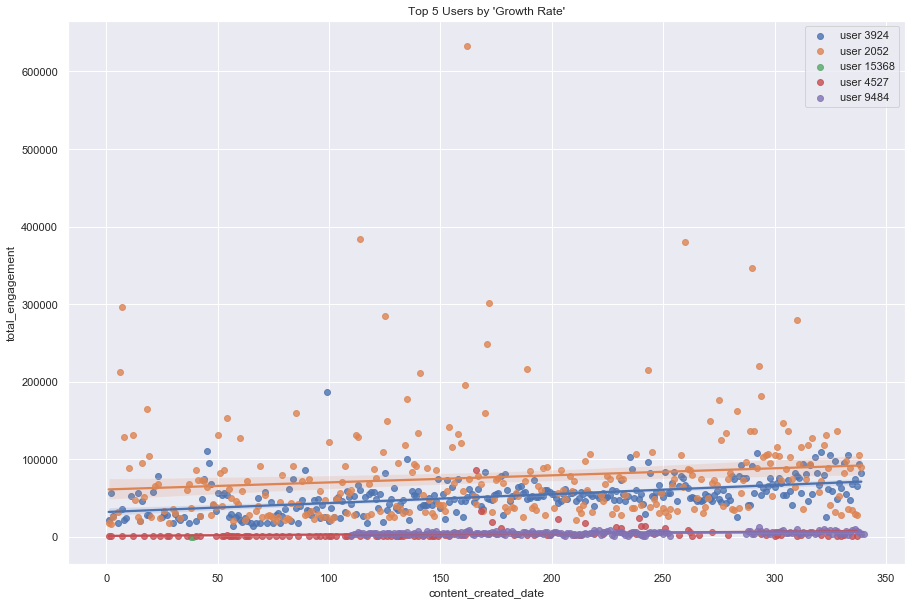

In [16]:
to_plot=df_engag_trend.head(5).index
plot_user(*to_plot,title="Top 5 Users by 'Growth Rate'")

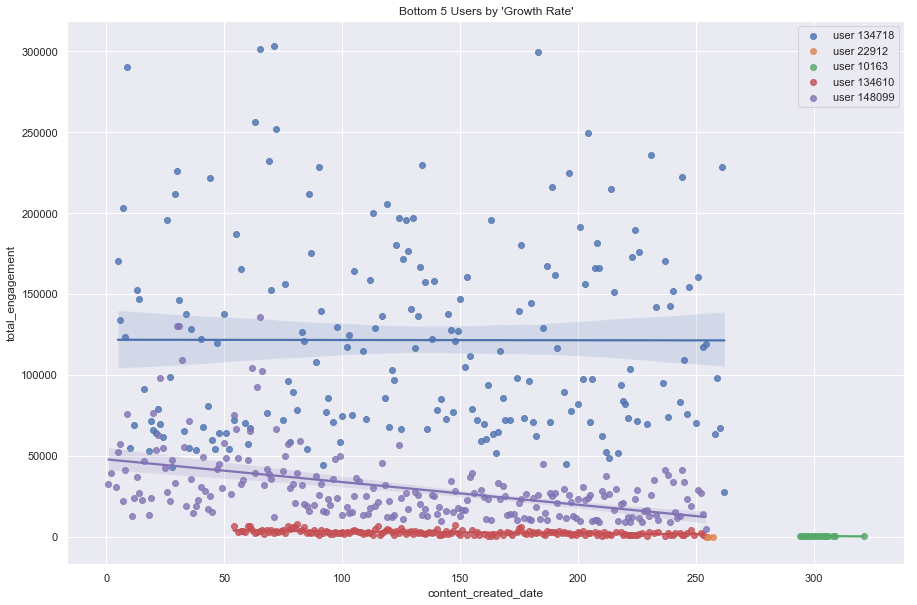

In [17]:
to_plot=df_engag_trend.tail(5).index
plot_user(*to_plot,title="Bottom 5 Users by 'Growth Rate'")

As can be seen from the prior plot, even though 'user 134718' has very high total engagement, their growth rate is almost 0 resulting in them ending up in the bottom 5 in terms of “fastest growing user”.

In [18]:
df_engag_trend.tail(5)

,positive_engag_trend
user_id,
134718,-1.443114
22912,-4.428571
10163,-11.406492
134610,-11.989307
148099,-140.387095


## Question 2: Use the user, user_features & model_test_file datasets

In [19]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, accuracy_score
import scikitplot as skplt

In [20]:
#check if the user_id's in the 'user' sheet are in the same order as the user_ids 'user_features'
df['user']['user_id'].equals(df['user_features']['user_id'])

True

In [21]:
#features
x = df['user_features'].iloc[:,0:-1]

#labels
y = df['user'].loc[:,'response']

#features to apply model to
x_pred = df['model_test_file'].iloc[:,0:-1]

#create shuffled training and test sets 
#random state ensures repeatability of splitting
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=123)

A default logistic regression is first applied to the training data. On first inspection, an accuracy of 0.85 seems decent, until the contents of the predictions are looked at.

In [22]:
lrc = LogisticRegression()

lrc.fit(x_train, y_train)  
y_pred = lrc.predict(x_test)
print("Accuracy: {}".format(round(accuracy_score(y_test,y_pred),3)))
print("Number of predictions: {}".format(len(y_pred)))
print("Number of predictions that aren't zero: {}".format( len(y_pred[~y_pred==0])))

Accuracy: 0.849
Number of predictions: 1064
Number of predictions that aren't zero: 0


In [23]:
def test_model(model,x_test,y_test):
    """
    This function calculates metrics for a given model with given test data and plots them.
    """
    y_pred = model.predict(x_test)
    y_probas = model.predict_proba(x_test)
    print("\tAccuracy: {}".format(round(accuracy_score(y_test,y_pred),3)))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f" % f1_score(y_test, y_pred))
    skplt.metrics.plot_roc_curve(y_test, y_probas)
    skplt.metrics.plot_precision_recall_curve(y_test, y_probas)

To avoid creating a meaningless model that only predicts a response type 0, class weights are introduced. This is necessary because of the imbalance in the supplied data, with ~85% of reponses being 1 with the rest 0's. 

A Stratified K-Folds cross-validator was used to find the best parameters for the model.

Additional metrics, defined in the above function 'test_model', were also used to determine the optimal classifier.
Precision and Recall were combined in the form of F1 scores, which were used as the main metric to validate models.
Precision-Recall curves were used to visualize this information. 

	Accuracy: 0.78
	Precision: 0.399
	Recall: 0.894
	F1: 0.552


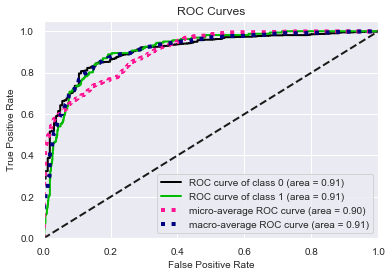

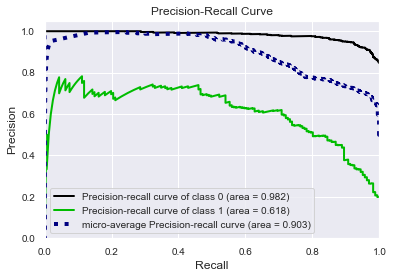

In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=10)
lrc = LogisticRegressionCV(solver='newton-cg',class_weight={0:15,1:85},cv=skf,scoring=None)

y_score=lrc.fit(x_train, y_train)  
test_model(lrc,x_test,y_test)

Notes:
+ No information was given about interpretting the responses or user variables
 + Cannot truely optimize between predicting all 1 responses while not triggering False Positives without this information 
 + This model was choose because it acheived the highest F1 score on the testing set
+ It should be noted that this model preforms worse in terms of accuracy than simply predicting only 0's
+ Additional techniques and models were explored below, but not used in the final model


















In [30]:
y_pred=lrc.predict(x_pred)
y_pred

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1])

The above array is the predicted results based on the logistic regression model

## Abandoned techniques

[False False False False False False False False False False False  True]
[ 3  2 10 12  5 11  6  8  4  7  9  1]
	Accuracy: 0.77
	Precision: 0.387
	Recall: 0.894
	F1: 0.540


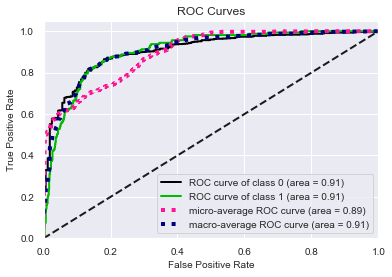

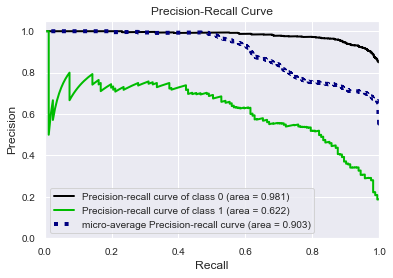

In [26]:
# Recursive Feature Elimination
#Although it seems the features could be reduced down to just 1 while still maintaining a similar F1 score,
#No improvements in f1 score or accuracy were seen, so this was abandoned

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegressionCV(solver='newton-cg',class_weight={0:15,1:85},cv=skf,scoring=None)
# create the RFE model and select 1 feature
rfe = RFE(model, 1)
rfe = rfe.fit(x_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

# y_score=rfe.fit(x_train, y_train)  
test_model(rfe,x_test,y_test)

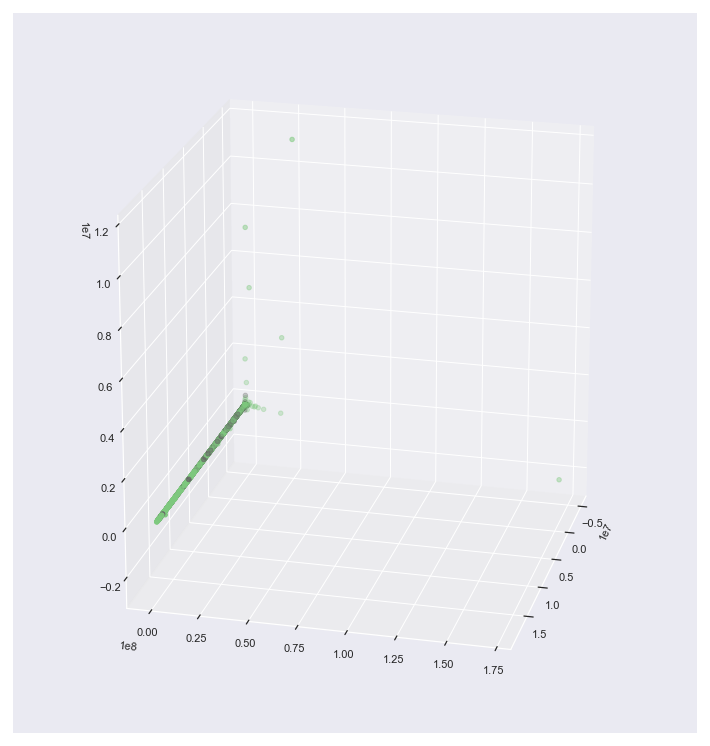

In [25]:
#PCA: Cannot clearly see differences in reponses in just 3 dimensions
#because PCA doesn't provide helpful visuals and isn't necessary to reduce training time, this was abandoned
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition

X = x

fig = plt.figure(1, figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=14)

pca = decomposition.PCA(n_components=3)
pca.fit(x)
x = pca.transform(x)

ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y, cmap=plt.cm.Accent)

	Accuracy: 0.633
	Precision: 0.276
	Recall: 0.882
	F1: 0.421


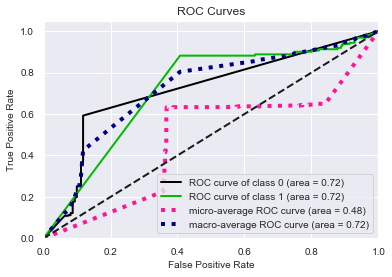

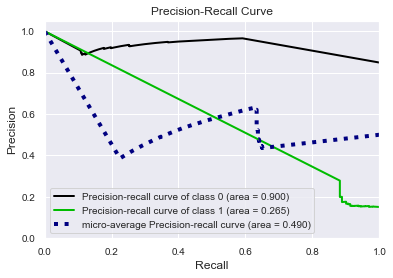

In [28]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(100,11), random_state=1)

y_score=clf.fit(x_train, y_train)  
test_model(clf,x_test,y_test)